# Diabetic Retinopathy Classification Using MobileNetV2-SVM

# ABSTRACT
Deep learning has been proposed as one of the automated solutions for diabetic retinopathy (DR) severity classification problem. However, most of the successful deep learning models are based on large convolutional neural network (CNN) architectures, requiring a vast volume of training data as well as dedicated computational resources. In [previous study](https://www.kaggle.com/shidqiet/diabetic-retinopathy-mobilenetv2), we used MobileNetV2 architecture, which was considered a small-scale architecture (4.2 million trainable parameters), to perform DR classification task in APTOS 2019 dataset (3662 color retinal images). **In this study, we further optimized our model by implemented data augmentation and resampling during training and combining it with an SVM classifier, resulting a hybrid and computationally efficient deep learning model, MobileNetV2-SVM.**

# Import Library

In [1]:
# Import Library

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from PIL import Image

from keras import layers
from tensorflow.keras import applications 
from keras.applications import MobileNetV2
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.optimizers import Adam


from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix

from tqdm import tqdm

Using TensorFlow backend.


# Loading Data and Exploration

## Loading data

Loading the csv data which contains the images file name and its labels. In this project I am using data that already splitted for training and validation.

In [2]:
train_df = pd.read_csv('../input/valid-and-test-ta/x_train_8.csv')
valid_df = pd.read_csv('../input/valid-and-test-ta/x_valid_8.csv')
print(train_df.shape)
print(valid_df.shape)
train_df.head()

(3297, 2)
(365, 2)


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


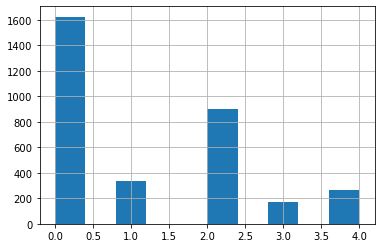

In [3]:
train_df['diagnosis'].value_counts()
train_df['diagnosis'].hist()

## Displaying some Sample Images
Display the color retinal images with its label as the title

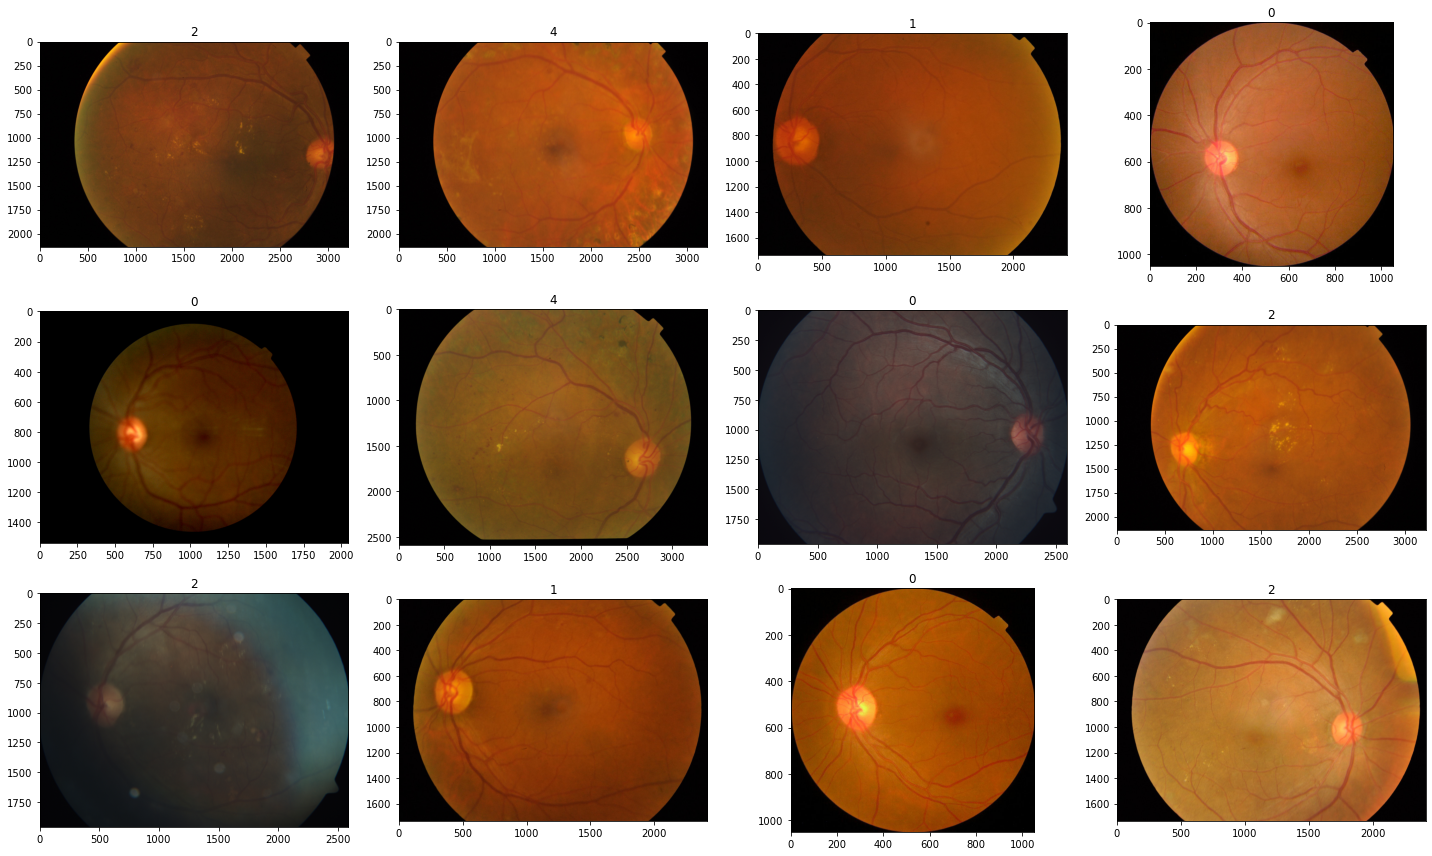

In [4]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'../input/aptos2019-blindness-detection/train_images/{image_path}.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)

# Preprocessing

## Sampling Data

Data is sampled into 700 data for each class

In [5]:
#resample
from sklearn.utils import resample
X=train_df
normal=X[X.diagnosis==0]
mild=X[X.diagnosis==1]
moderate=X[X.diagnosis==2]
severe=X[X.diagnosis==3]
pdr=X[X.diagnosis==4]

#downsampled
mild = resample(mild,
                replace=True, # sample with replacement
                n_samples=700, # match number in majority class
                random_state=2020) # reproducible results
moderate = resample(moderate,
                    replace=False, # sample with replacement
                    n_samples=700, # match number in majority class
                    random_state=2020) # reproducible results
severe = resample(severe,
                  replace=True, # sample with replacement
                  n_samples=700, # match number in majority class
                  random_state=2020) # reproducible results
normal = resample(normal,
                  replace=False, # sample with replacement
                  n_samples=700, # match number in majority class
                  random_state=2020) # reproducible results
pdr = resample(pdr,
               replace=True, # sample with replacement
               n_samples=700, # match number in majority class
               random_state=2020) # reproducible results    

# combine minority and downsampled majority
sampled = pd.concat([normal, mild, moderate, severe, pdr])

# checking counts
sampled.diagnosis.value_counts()

train_df = sampled
train_df = train_df.sample(frac=1).reset_index(drop=True)

## Pre-processing : Resize Images
We will resize the images to 224x224 pixel (MobileNetV2 default input resolution), then create a single numpy array to hold the data (because the data is not too much).

In [6]:
def preprocess_image(image_path, desired_size=224):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.BILINEAR)
    
    return im

N = train_df.shape[0]
x_train = np.empty((N, 224, 224, 3), dtype=np.float32)

for i, image_id in enumerate(tqdm(train_df['id_code'])):
    x_train[i, :, :, :] = preprocess_image(
        f'../input/aptos2019-blindness-detection/train_images/{image_id}.png'
    )
    
N = valid_df.shape[0]
x_val = np.empty((N, 224, 224, 3), dtype=np.float32)

for i, image_id in enumerate(tqdm(valid_df['id_code'])):
    x_val[i, :, :, :] = preprocess_image(
        f'../input/aptos2019-blindness-detection/train_images/{image_id}.png'
    )

100%|██████████| 365/365 [00:52<00:00,  6.89it/s]


In [7]:
y_train = train_df['diagnosis']
y_val = valid_df['diagnosis']
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(3500, 224, 224, 3)
(3500,)
(365, 224, 224, 3)
(365,)


# Model: MobilenetV2

I am using MobileNetV2 architecture in this project. The architecture is adopted from [1], where they choose 1.3 as the width multiplier/ alpha (MobileNetV2 hyperparameter). They customize the last layer of the model to become 2 dense layer with 256 nodes and 1 nodes output layer. They use regression approach for this problem because diabetic retinopathy severity is an ordinal variables. Linear activation function is used in the output layer.

In [8]:
model = load_model('../input/diabetic-retinopathy-mobilenetv2/model.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.30_224 (Model) (None, 7, 7, 1664)        3766048   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1664)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               426240    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 4,258,337
Trainable params: 4,214,081
Non-trainable params: 44,256
_________________________________________________________________


## Check performance on validation data

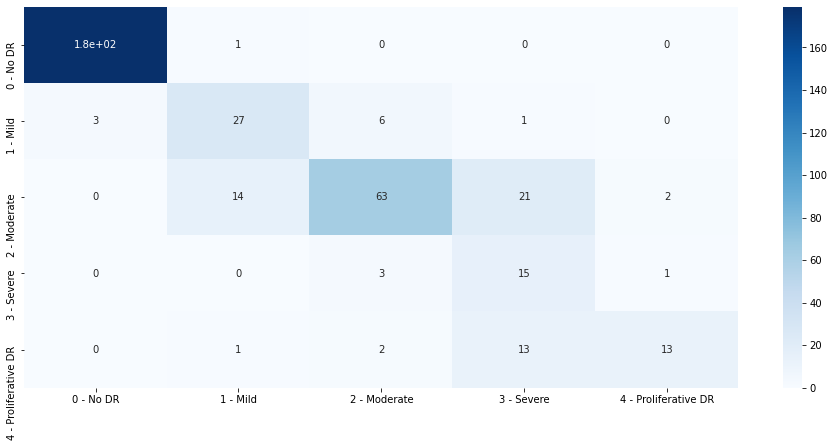

In [9]:
y_val_pred = model.predict(x_val)
y_val_pred = np.clip(y_val_pred,0,4).astype(int)

labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(valid_df['diagnosis'].astype('int'), y_val_pred)
df_cm = pd.DataFrame(cnf_matrix, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, cmap="Blues")
plt.show()

In [10]:
kappa_val = cohen_kappa_score(
            valid_df['diagnosis'].astype('int'),
            y_val_pred, 
            weights='quadratic'
        )
kappa_val

0.924615017986632

In [11]:
from sklearn.metrics import classification_report
target_names = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
print(classification_report(valid_df['diagnosis'].astype('int'), y_val_pred, target_names=target_names))

                      precision    recall  f1-score   support

           0 - No DR       0.98      0.99      0.99       180
            1 - Mild       0.63      0.73      0.68        37
        2 - Moderate       0.85      0.63      0.72       100
          3 - Severe       0.30      0.79      0.43        19
4 - Proliferative DR       0.81      0.45      0.58        29

            accuracy                           0.81       365
           macro avg       0.72      0.72      0.68       365
        weighted avg       0.86      0.81      0.82       365



# MobileNetV2-SVM

In most transfer learning approach, the pre-trained weights of the convolutional layers are left intact while the fully-connected layers are re-trained with the specific dataset. The motivation for such approach is the assumption that the convolutional layers pre-trained in large-scale dataset are already an optimum generic feature extractor on their current state. Following such procedure, we investigated the utilization of the MobileNetV2 convolutional layers as a fixed feature extractor, while replacing the fully-connected layer (i.e. the feature classifier) with different types of classifiers that may offer more flexibility, for instance the Support Vector Machine (SVM). 

## Import Library

In [12]:
from sklearn.svm import SVC

from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline

from sklearn.metrics import roc_curve, auc

from sklearn.multiclass import OneVsOneClassifier

from scipy import interp

## Removing The Output Layer



In [13]:
import keras
layer_name = 'dense_2'
intermediate_layer_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer(layer_name).output)
intermediate_layer_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.30_224_input ( (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.30_224 (Model) (None, 7, 7, 1664)        3766048   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1664)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               426240    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
Total params: 4,258,080
Trainable params: 4,213,824
Non-trainable params: 44,256
_________________________________________________________________


## Extract 256 Features from each images

In [14]:
y_train_pred = intermediate_layer_model.predict(x_train)
y_valid_pred = intermediate_layer_model.predict(x_val)

## Training SVM

In [15]:
y_val = label_binarize(y_val, classes=[0,1,2,3,4])
# classifier
clf = make_pipeline(StandardScaler(),SVC(probability=True))
clf = OneVsOneClassifier(clf)
y_score = clf.fit(y_train_pred, y_train).decision_function(y_valid_pred)

# Evaluate

## Quadratic Weighted Kappa

In [16]:
kappa_val = cohen_kappa_score(
            np.argmax(y_val,axis=1),
            np.argmax(y_score,axis=1), 
            weights='quadratic'
        )

print(kappa_val)

0.9235448792227471


## AUROC

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


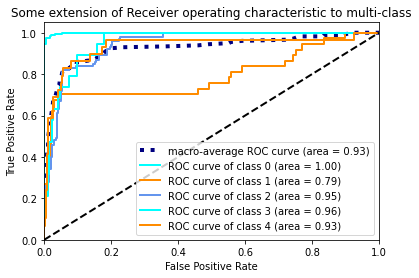

In [17]:
n_classes = 5

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

from itertools import cycle
lw = 2
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


## Confusion Matrix

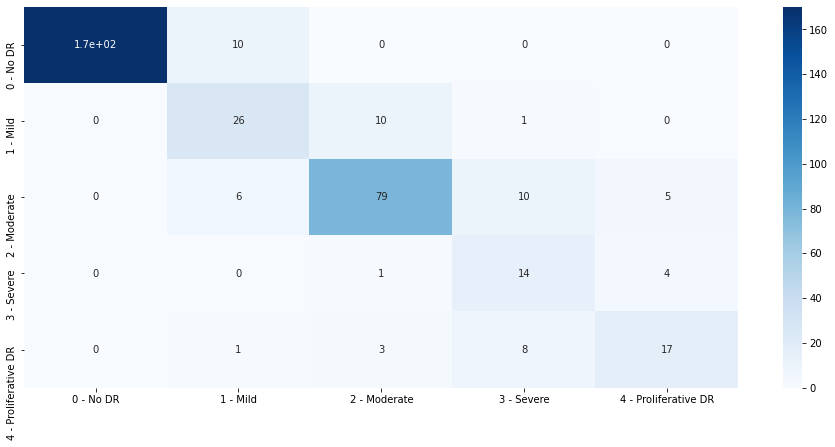

In [18]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(np.argmax(y_val,axis=1), np.argmax(y_score,axis=1))
df_cm = pd.DataFrame(cnf_matrix, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, cmap="Blues")
plt.show()

## Accuracy etc.

In [19]:
from sklearn.metrics import classification_report
target_names = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
print(classification_report(np.argmax(y_val,axis=1), np.argmax(y_score,axis=1), target_names=target_names))

                      precision    recall  f1-score   support

           0 - No DR       1.00      0.94      0.97       180
            1 - Mild       0.60      0.70      0.65        37
        2 - Moderate       0.85      0.79      0.82       100
          3 - Severe       0.42      0.74      0.54        19
4 - Proliferative DR       0.65      0.59      0.62        29

            accuracy                           0.84       365
           macro avg       0.71      0.75      0.72       365
        weighted avg       0.86      0.84      0.85       365

